# Gaussian process regression

A Gaussian Process (GP) is a collection of random variable for which any finite sub-collection of random variable have a joint gaussian distribution. In the context of machine learning, these random variables corresponds to functions and a GP can be understood as a distribution over functions.

## Prior


First, let's generate some input data $X$ as well as some test data $X^*$ and define the function $y=sin(x)+\varepsilon$,  with $\varepsilon \sim 0.1*\mathcal{U}(0,1)$.
  

As a prior we assume  that $f \sim GP\big(m(x),k(x,x')\big)$ $\textit{i.e}$  that $p\big(f(x_1),...,f(X_N)\big) \sim \mathcal{N}\big(m(x),k(x,x')\big)$.

Let's define a prior $p(f|x) \sim \mathcal{N(0,k)}$.

We make the asumption that our function of interest is centered in zero and is defined by a multivariate normal distribution.
We also make the asumption that the  kernel function representing the dependence structure of this distribution can be modeled using a RBF kernel or Gaussian kernel, defined as
$$ k(x,x')= \sigma^2_f exp^{(-\frac{||x-x'||^2}{2\lambda^2})}$$


First, we directly draw some samples from our prior. We plot the samples as well as the true targets $y$ to compare them.



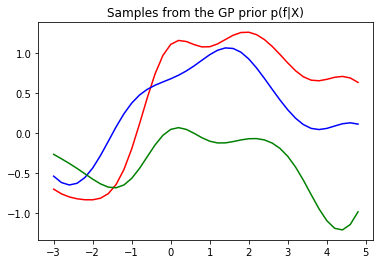

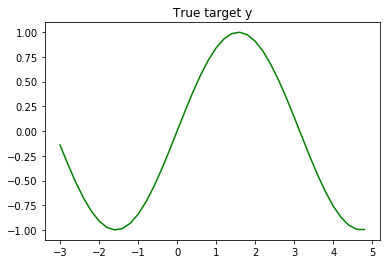

In [15]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# squared exponential kernel aka Gaussian kenrel aka RBF kernel
def kernel(X1, X2, l=1.0, sigma_f=0.5):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)



# Training set
X_train = np.arange(-10, 10, 1).reshape(-1, 1)
Y_train = np.sin(X_train) 
# Test set
X_test= np.arange(-3, 5, 0.2).reshape(-1, 1)
Y_test = np.sin(X_test) 


# Mean and covariance of the prior
mu = np.zeros(X_test.shape)
cov = kernel(X_test,X_test)

# Draw samples from the prior
sample = np.random.multivariate_normal(mu.ravel(), cov, 3)

#print('Sample from the prior: ',sample )
plt.plot(X_test,sample[0], 'r') # plotting t, a separately 
plt.plot(X_test,sample[1], 'b') # plotting t, b separately 
plt.plot(X_test,sample[2], 'g') # plotting t, c separately 
plt.title('Samples from the GP prior p(f|X)')
plt.show()

plt.plot(X_test,Y_test, 'g') # plotting t, c separately 
plt.title('True target y')
plt.show()



We can see that our prior are not very informed and doesn't appear to be close to the true function.

Next, let's use the training data to compute the posterior distribution $ p(f^*|X*,X,Y)$

## Posterior

It can be shown \footnote{See \cite{Rasmussen}} that the posterior predictive density is defined as follow:

$$ p(f^*|X*,X,Y) = \mathcal{N}(f^*|\mu^*,\Sigma_*) \\ $$
With  $ \mu^* = m(X^*) + k(X, X^*) [k(X, X) + \sigma_\varepsilon^2 \textbf{I}]^{-1} Y $ \\
and $ \Sigma_* = K(X, X^*) [k(X, X^*) + \sigma_\varepsilon^2 I]^{-1} K(X, X^*)$

Where $k(X,X)$ is the covariance matrix of the training set, $k(X,X^*)$ the covariance matrix between the points of the training set and the points of the test set and $k(X^*,X^*)$ the covariance matrix of the test set.

After the computation of $ \mu^*$ $ \Sigma_*$, we can get a prediction by taking the mean of the distribution.

We use the posterior distribution to predict the targets given the test set $X^*$.

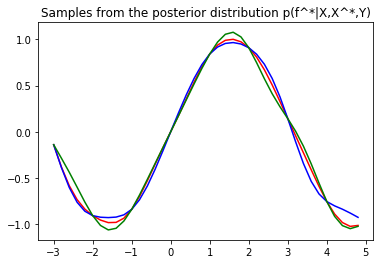

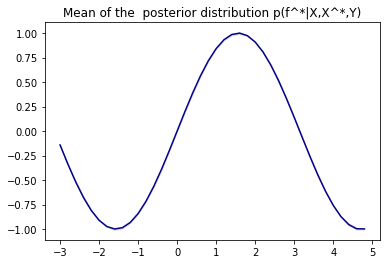

In [3]:
from numpy.linalg import inv

def posterior_predictive(X, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):

    
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X, l, sigma_f) 
    K_ss = kernel(X, X, l, sigma_f) + (1e-8)**2 * np.eye(len(X)) # test set covariance matrix  
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s




# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X_test, X_train, Y_train, sigma_y=1e-8)
sample = np.random.multivariate_normal(mu_s.ravel(), cov_s, 10000)

#print('Sample from the posterior: ',sample )
plt.plot(X_test,sample[0], 'r') # plotting t, a separately 
plt.plot(X_test,sample[1], 'b') # plotting t, b separately 
plt.plot(X_test,sample[2], 'g') # plotting t, c separately 
#
plt.title('Samples from the posterior distribution p(f^*|X,X^*,Y)')
plt.show()

mean = np.mean(sample,0)
sd = np.diagonal(cov_s)
plt.plot(X_test,mean, 'darkblue') 
plt.gca().fill_between(X_test.flat, mean-1.96*sd, mean+1.96*sd, color="#dddddd")  # 95% confidence interval
plt.title('Mean of the  posterior distribution p(f^*|X,X^*,Y)')
plt.show()

# plt.plot(X_test,Y_test, 'g') # plotting t, c separately 
# plt.title('True target y (without noise)')
# plt.show()


# Bayesian optimization toy example (SMBO)

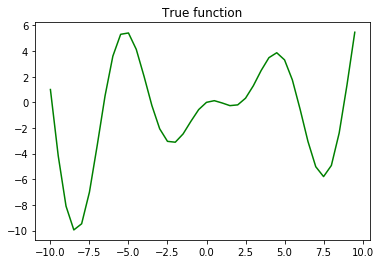

In [0]:
noise = 0.2

# function to optimize
def f(X,noise=noise):
    return np.sin(X)+0.1*X +noise * np.random.randn()+np.cos(X+2)*X

bounds = np.array([[-10, 10]])

# Dense grid of points within bounds
X = np.arange(bounds[0][0],bounds[0][1], 0.5).reshape(-1, 1)
# Noise-free objective function values at X 
Y = f(X,0)

# initial point
X_train = np.random.uniform(bounds[0][0],bounds[0][1],2).reshape(-1, 1)
Y_train = f(X_train,noise)


plt.plot(X,Y, 'g') # plotting t, c separately 
plt.title('True function')
plt.show()


In [0]:

def GPSurrogate(X, X_train, Y_train, l=1.0, sigma_f=np.std(Y), sigma_y=1e-8):
    mean, cov_s = posterior_predictive(X, X_train, Y_train,sigma_f=sigma_f, sigma_y=noise)
#     print(mean.shape)
#     print(cov_s.shape)
    sample = np.random.multivariate_normal(mean.ravel(), cov_s, 1000)
    #tMean = np.mean(sample,0)
    sd = np.sqrt(np.diagonal(cov_s))
    return mean, sd


# Acquisition function (adapted from http://krasserm.github.io/2018/03/21/bayesian-optimization/)

def expected_improvement(X, X_train, Y_train, xi=0.01):
    ''' Computes the EI at points X based on existing samples X_sample and Y_sample using a Gaussian process surrogate model. Args: X: Points at which EI shall be computed (m x d). X_sample: Sample locations (n x d). Y_sample: Sample values (n x 1). gpr: A GaussianProcessRegressor fitted to samples. xi: Exploitation-exploration trade-off parameter. Returns: Expected improvements at points X. '''
    mean, sd = GPSurrogate(X,X_train,Y_train)
    tMean, _ = GPSurrogate(X_train,X_train,Y_train)

    #mu_sample = gpr.predict(X_sample)

    sd = sd.reshape(-1, X_train.shape[1])
    
    # closed form for noise-based model,
    # otherwise simply use np.max(Y_sample).
    # See  http://ash-aldujaili.github.io/blog/2018/02/01/ei/
    tMeanOpt = np.min(tMean)
        
    with np.errstate(divide='warn'):
        imp = tMeanOpt-mean  #- xi
        Z = imp / sd
        ei = imp * norm.cdf(Z) + sd * norm.pdf(Z)
        ei[sd == 0.0] = 0.0


    return ei

from scipy.stats import norm
from scipy.optimize import minimize



def propose_location(acquisition, X_train, Y_train, bounds, n_restarts=50):
    ''' Proposes the next sampling point by optimizing the acquisition function. Args: acquisition: Acquisition function. X_sample: Sample locations (n x d). Y_sample: Sample values (n x 1). gpr: A GaussianProcessRegressor fitted to samples. Returns: Location of the acquisition function maximum. '''
    dim = X_train.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_train, Y_train)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[0][0], bounds[0][1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            #print(res.fun[0])
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)
    #print(np.min(-acquisition(X.reshape(-1, dim), X_train, Y_train)))
    #return np.min(-acquisition(X.reshape(-1, dim), X_train, Y_train))



In [0]:
# STucK IN LOCLA OPTIMA 
# good variance estimate ( local variance?)
#1 increase exploration
#2 improve initializaiton (latin cube)


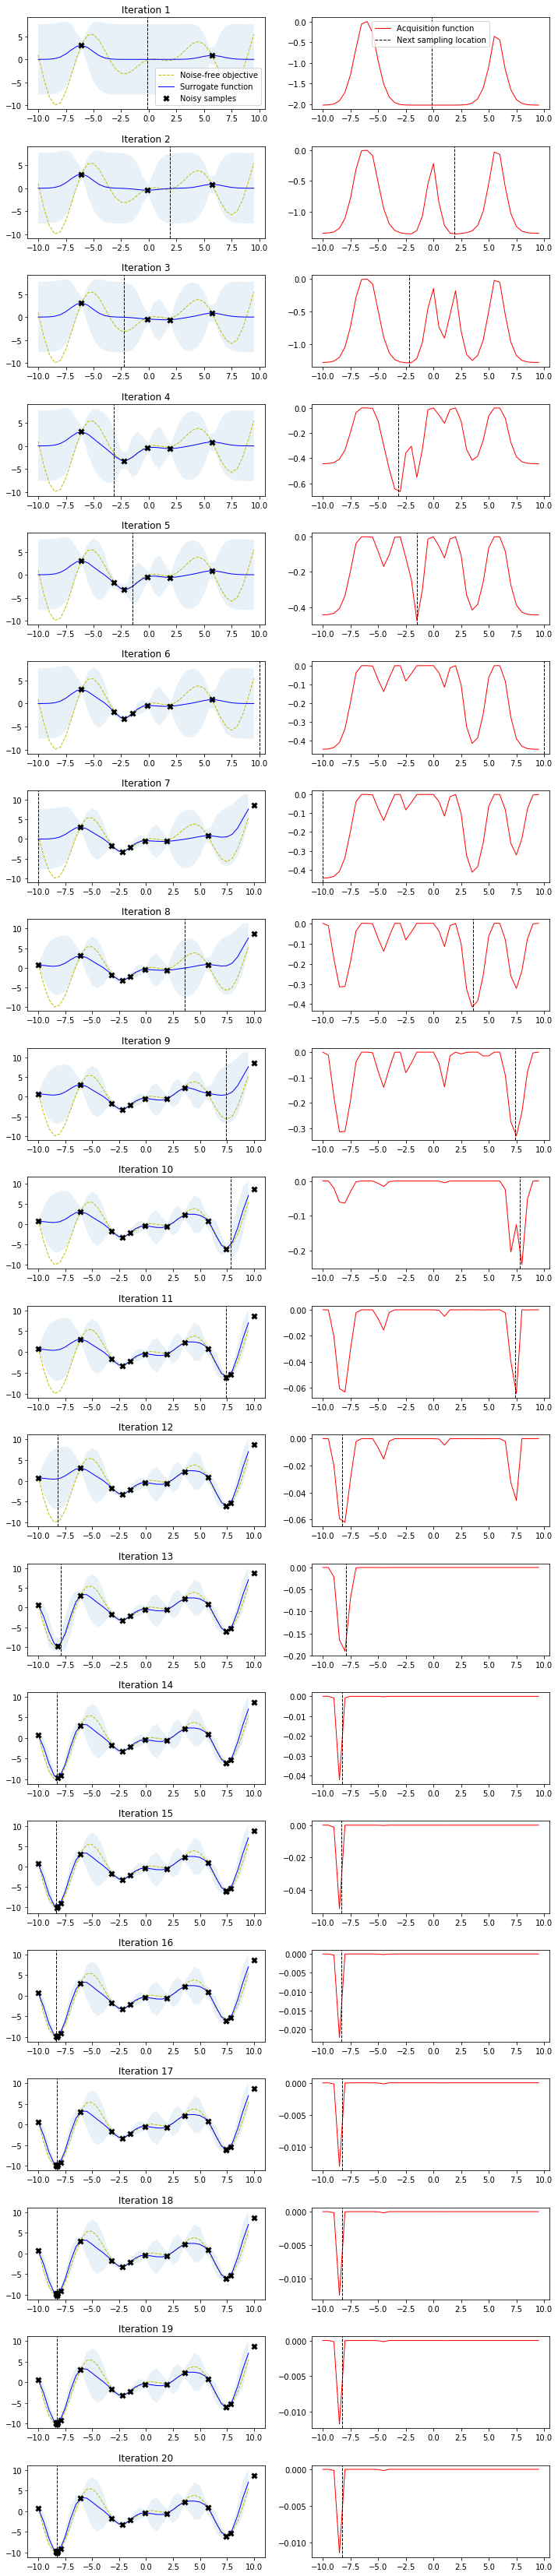

In [0]:
# to try: Gaussian process with Mattern kernel as surrogate model
#ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)



# Number of iterations
n_iter = 20


plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_train, Y_train, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next,noise)
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(X, Y, X_train, Y_train, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, -expected_improvement(X.reshape(-1, X_train.shape[1]), X_train, Y_train), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_train = np.vstack((X_train, X_next))
    Y_train = np.vstack((Y_train, Y_next))

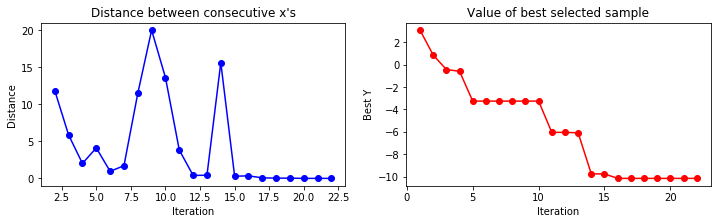

In [0]:

plot_convergence(X_train, Y_train)

In [0]:
import matplotlib.pyplot as plt

def plot_approximation(X, Y, X_train, Y_train, X_next=None, show_legend=False):
    #sMean, _ = GPSurrogate(X, X_train, Y_train)
    mean, sd = GPSurrogate(X, X_train, Y_train)
    plt.fill_between(X.ravel(), 
                     mean.ravel() + 1.96 * sd, 
                     mean.ravel() - 1.96 * sd, 
                     alpha=0.1) 
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mean, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_train, Y_train, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_train,Y_train, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_train.ravel()
    y = Y_train.ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.minimum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

## References

For code: [Nando de Freitas Machine Learning lectures ](http://www.cs.ubc.ca/~nando/540-2013/lectures/gp.py)

For theory: Carl Edward Rasmussen.  Gaussian processes for machine learning.  MIT Press, 2006. (if you want to learn the link between the bayesian linear model et the GP regression or to understand why the number of parameter in GP regression is potentially infinite )*0